In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.color import rgb2lab, lab2rgb, gray2rgb
from skimage.transform import resize
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential, Model
from keras.layers import Conv2D, Conv3D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, concatenate
from keras.layers import Activation, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
train_path = r'dataset'

In [6]:
train_datagen = ImageDataGenerator(rescale = 1/255, rotation_range = 50, horizontal_flip= True, vertical_flip = True)

In [7]:
train_data = train_datagen.flow_from_directory(train_path, target_size= (256,256), batch_size = 256, shuffle = True)

Found 13898 images belonging to 2 classes.


In [8]:
train_image, label = next(train_data)


In [9]:
X =[]
Y =[]

for img in train_image:
    try:
        lab = rgb2lab(img)
        X.append(lab[:,:,0])
        Y.append(lab[:,:,1:] / 128)
    except:
        print('error')

In [10]:
X_train = np.array(X)
X_train = X_train.reshape(X_train.shape+(1,))

y_train = np.array(Y)

In [11]:
print(X_train.shape)
print(y_train.shape)

(256, 256, 256, 1)
(256, 256, 256, 2)


In [12]:
vggmodel = tf.keras.applications.vgg16.VGG16(include_top=False, input_shape=(256, 256, 3))

In [13]:
for layer in vggmodel.layers[:19]:
    layer.trainable = False

In [14]:
vggmodel.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [15]:
vggfeatures = []
for i, sample in enumerate(X_train):
    sample = gray2rgb(sample)
    sample = sample.reshape((1,256,256,3))
    prediction = vggmodel.predict(sample)
    prediction = prediction.reshape((8,8,512))
    vggfeatures.append(prediction)
vggfeatures = np.array(vggfeatures)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1

In [16]:
vggfeatures.shape

(256, 8, 8, 512)

In [17]:
encoder_input = Input(shape=(8, 8, 512,))
decoder_output = Conv2DTranspose(256, (3,3), activation='relu', padding='same')(encoder_input)
decoder_output = Conv2DTranspose(128, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2DTranspose(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2DTranspose(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2DTranspose(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2DTranspose(2, (3, 3), activation='tanh', padding='same')(decoder_output)
output = UpSampling2D((2, 2))(decoder_output)

In [18]:
model = Model(inputs=encoder_input, outputs=output)

In [19]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 256)      │     1,179,904 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 8, 8, 128)      │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 64, 64, 16)     │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 128, 128, 2)    │           290 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 256, 256, 2)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,572,114 (6.00 MB)

 Trainable params: 1,572,114 (6.00 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(optimizer =Adam(learning_rate = 0.0002), loss='mse' , metrics=['accuracy'])

In [21]:
model.fit(vggfeatures, y_train, batch_size=8, epochs=30, verbose= 2)

Epoch 1/30
32/32 - 2s - 78ms/step - accuracy: 0.5739 - loss: 0.0821
Epoch 2/30
32/32 - 1s - 22ms/step - accuracy: 0.6186 - loss: 0.0112
Epoch 3/30
32/32 - 1s - 21ms/step - accuracy: 0.6355 - loss: 0.0100
Epoch 4/30
32/32 - 1s - 20ms/step - accuracy: 0.6440 - loss: 0.0096
Epoch 5/30
32/32 - 1s - 21ms/step - accuracy: 0.6596 - loss: 0.0093
Epoch 6/30
32/32 - 1s - 21ms/step - accuracy: 0.6261 - loss: 0.0091
Epoch 7/30
32/32 - 1s - 21ms/step - accuracy: 0.6562 - loss: 0.0087
Epoch 8/30
32/32 - 1s - 21ms/step - accuracy: 0.6451 - loss: 0.0083
Epoch 9/30
32/32 - 1s - 21ms/step - accuracy: 0.6415 - loss: 0.0080
Epoch 10/30
32/32 - 1s - 21ms/step - accuracy: 0.6398 - loss: 0.0077
Epoch 11/30
32/32 - 1s - 21ms/step - accuracy: 0.6255 - loss: 0.0075
Epoch 12/30
32/32 - 1s - 21ms/step - accuracy: 0.6390 - loss: 0.0071
Epoch 13/30
32/32 - 1s - 21ms/step - accuracy: 0.5893 - loss: 0.0068
Epoch 14/30
32/32 - 1s - 21ms/step - accuracy: 0.5908 - loss: 0.0064
Epoch 15/30
32/32 - 1s - 20ms/step - accura

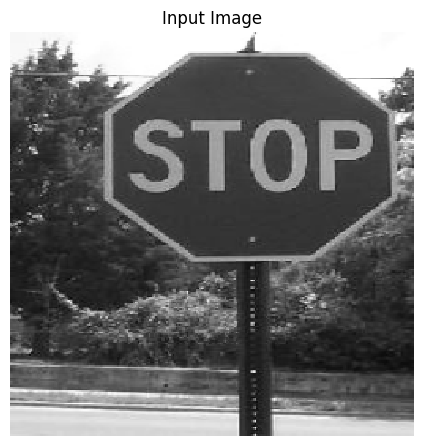

In [22]:
img1_color = []

path = r"d:\Personal\Grey_colour\pix2pix\Inputs\image_0052_aug1.png"

img = img_to_array(load_img(path))
img = resize(img, (256,256), anti_aliasing=True)
img*= 1.0/255

plt.title("Input Image")
imshow(img)
plt.axis('off')
plt.show()

In [23]:
lab = rgb2lab(img)
l = lab[:,:,0]
L = gray2rgb(l)
L = L.reshape((1,256,256,3))

In [24]:
output = vggmodel.predict(L)
ab = model.predict(output)
ab = ab * 128

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


In [25]:
cur = np.zeros((256, 256, 3))
cur[:,:,0] = l
cur[:,:,1:] = ab

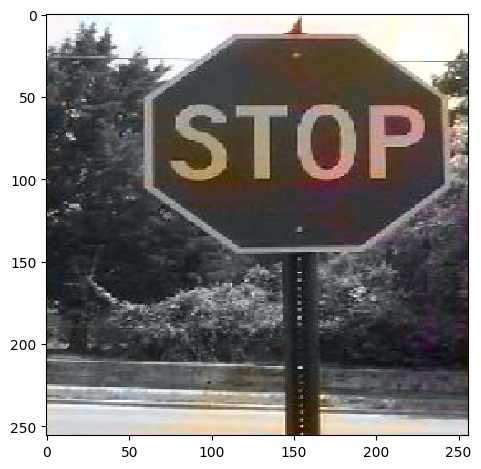

In [26]:
imshow(lab2rgb(cur))

In [27]:
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2lab, gray2rgb, lab2rgb
from keras.preprocessing.image import img_to_array, load_img

# Paths to input images
input_image_paths = [
    r"Inputs\ba1 (2)_aug4.png",
    r"Inputs\bt (1)_aug3.png",
    r"Inputs\bt (7)_aug1.png",
    r"Inputs\cf (11)_aug1.png",
    r"Inputs\Common-Kingfisher_18_aug2.png",
    r"Inputs\download (15)_aug0.png",
    r"Inputs\egg (2)_aug0.png",
    r"Inputs\el (20).jpg",
    r"Inputs\image_0052_aug1.png",
    r"Inputs\Indian-Peacock_157_aug3.png",
    r"Inputs\n02391049_141_aug4.png",
    r"Inputs\pexels-asadphoto-457878_aug3.png",
    r"Inputs\rd (18)_aug1.png",
    r"Inputs\Red Rose New (25).jpg",
    r"Inputs\rf (11)_aug2.png",
    r"Inputs\sky_image_2.jpg",
    r"Inputs\banana_tree.jpeg",
    r"Inputs\grass.jpeg",
    r"Inputs\sky_image.jpeg",
]

# Directory to save the processed images
output_dir = "VGG_Resultant_images"
os.makedirs(output_dir, exist_ok=True)

# Loop through and process each image
for idx, path in enumerate(input_image_paths):
    try:
        # Load and preprocess the image
        img = img_to_array(load_img(path))
        img = resize(img, (256, 256), anti_aliasing=True)
        img *= 1.0 / 255

        # Convert image to LAB and process with VGG and your model
        lab = rgb2lab(img)
        l = lab[:, :, 0]
        L = gray2rgb(l)  # Convert grayscale to RGB for VGG model
        L = L.reshape((1, 256, 256, 3))

        # Predict features using VGG model
        output = vggmodel.predict(L)

        # Predict colorization using your model
        ab = model.predict(output)
        ab = ab * 128  # Scale back the ab channels

        # Combine L and ab channels to create the colorized image
        cur = np.zeros((256, 256, 3))
        cur[:, :, 0] = l
        cur[:, :, 1:] = ab

        # Convert LAB to RGB
        colorized_img = lab2rgb(cur)

        # Save the processed image
        save_path = os.path.join(output_dir, f"processed_image_{idx + 1}.png")
        plt.imsave(save_path, colorized_img)
        print(f"Saved: {save_path}")
    except Exception as e:
        print(f"Error processing {path}: {e}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Saved: VGG_Resultant_images\processed_image_1.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Saved: VGG_Resultant_images\processed_image_2.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Saved: VGG_Resultant_images\processed_image_3.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Saved: VGG_Resultant_images\processed_image_4.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Saved: VGG_Resultant_images\processed_image_5.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Saved: VGG_Resultant_images\processed_image_6.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Saved: VGG_Resultant_images\processed_image_7.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


C:\Users\venka\AppData\Local\Temp\ipykernel_87272\2709689887.py:63: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 56 negative Z values that have been clipped to zero
  colorized_img = lab2rgb(cur)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Saved: VGG_Resultant_images\processed_image_8.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Saved: VGG_Resultant_images\processed_image_9.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Saved: VGG_Resultant_images\processed_image_10.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Saved: VGG_Resultant_images\processed_image_11.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Saved: VGG_Resultant_images\processed_image_12.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Saved: VGG_Resultant_images\processed_image_13.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Saved: VGG_Resultant_images\processed_image_14.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Saved: VGG_Resultant_images\processed_image_15.png
1/1 ━━━━━━━━━━━━━